In [22]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
from PIL import Image
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [40]:
# Transformation en tenseur :
# Augmentation du dataset (n'augmente pas la taille du dataset, mais il faut augmenter le nombre d'époque 
# par 2 pour chaque transformation)
t = transforms.Compose([transforms.Grayscale(), transforms.RandomRotation(30, resample=False, expand=False, center=None),transforms.ToTensor(),])


train_dataset = ImageFolder('/home/ysteux/nosave/PPC/Train/', transform = t)
test_dataset = ImageFolder('/home/ysteux/nosave/PPC/Test/', transform = t)

print("Training data:", train_dataset)
print("\nTest data:", test_dataset)
# Create DataLoader
# Dataloader train
dataloader_args = dict(shuffle=True, batch_size=45,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=45)
train_loader = dataloader.DataLoader(train_dataset, **dataloader_args)

# Dataloader test
dataloader_args = dict(shuffle=True, batch_size=len(test_dataset),num_workers=4, pin_memory=True)
test_loader = dataloader.DataLoader(test_dataset, **dataloader_args)

Training data: Dataset ImageFolder
    Number of datapoints: 135
    Root Location: /home/ysteux/nosave/PPC/Train/
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             ToTensor()
                         )
    Target Transforms (if any): None

Test data: Dataset ImageFolder
    Number of datapoints: 67
    Root Location: /home/ysteux/nosave/PPC/Test/
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [41]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 1024))
        # Activation relu sur fc
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=0)    
    
    
model = Model()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [58]:
EPOCHS = 100
losses = []

# Eval
data_iter = iter(test_loader)
evaluate_x, evaluate_y = data_iter.next()

if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
    
train_size = len(train_loader.dataset)
batch_size = (train_size / 20) if (cuda) else  (train_size / 20)

# On passe le modèle en training mode
model.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        
        # Mise à jour des poids 
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')

    # display final evaluation for this epoch
    # On passe le modèle en test mode
    model.eval()

    # Appel de la fonction forward
    output = model(evaluate_x)
    
    # Vecteur de prédiction des données de test
    pred = output.data.max(1)[1]
    
    # Test d'égalité entre données de test et prédiction
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 1/100 [135/135 (30%)]	Loss: 0.116203	 Test Accuracy: 44.7761%
 Train Epoch: 2/100 [135/135 (30%)]	Loss: 0.078398	 Test Accuracy: 46.2687%
 Train Epoch: 3/100 [135/135 (30%)]	Loss: 0.127719	 Test Accuracy: 46.2687%
 Train Epoch: 4/100 [135/135 (30%)]	Loss: 0.121815	 Test Accuracy: 43.2836%
 Train Epoch: 5/100 [135/135 (30%)]	Loss: 0.066645	 Test Accuracy: 41.7910%
 Train Epoch: 6/100 [135/135 (30%)]	Loss: 0.073389	 Test Accuracy: 44.7761%
 Train Epoch: 7/100 [135/135 (30%)]	Loss: 0.180658	 Test Accuracy: 44.7761%
 Train Epoch: 8/100 [135/135 (30%)]	Loss: 0.092386	 Test Accuracy: 43.2836%
 Train Epoch: 9/100 [135/135 (30%)]	Loss: 0.148302	 Test Accuracy: 46.2687%
 Train Epoch: 10/100 [135/135 (30%)]	Loss: 0.229158	 Test Accuracy: 44.7761%
 Train Epoch: 11/100 [135/135 (30%)]	Loss: 0.107738	 Test Accuracy: 46.2687%
 Train Epoch: 12/100 [135/135 (30%)]	Loss: 0.092866	 Test Accuracy: 46.2687%
 Train Epoch: 13/100 [135/135 (30%)]	Loss: 0.082239	 Test Accuracy: 46.2687%
 Train E

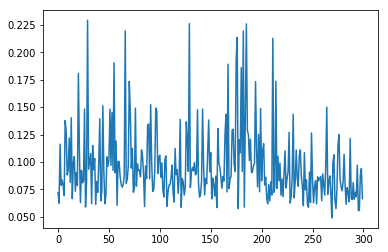

In [59]:
# Evolution des résultats de la fonction "loss" :
plt.plot(losses)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1216, 0.1490, 0.0000],
         [0.0510, 0.0157, 0.0235,  ..., 0.2980, 0.1529, 0.0000],
         [0.1373, 0.2235, 0.4157,  ..., 0.1569, 0.2118, 0.0000],
         ...,
         [0.0000, 0.4549, 0.4549,  ..., 0.2863, 0.2941, 0.2941],
         [0.0000, 0.4588, 0.4627,  ..., 0.2902, 0.2941, 0.2980],
         [0.0000, 0.4667, 0.4667,  ..., 0.0000, 0.0000, 0.0000]]]), 0)


ValueError: only one element tensors can be converted to Python scalars

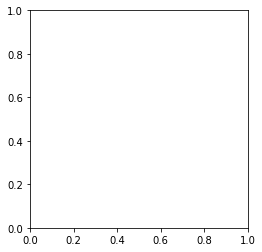

In [66]:
#for test_data in (test_dataset.size())
# Pour chaque image de test dans le test_dataset
    # Recupérer sa prédiction
    #prediction = pred(i)
    # Plot l'image, avec sa prédiction et sa réelle appartenance
    #img = Image.open('/home/ysteux/nosave/PPC/Train/Paper/Paper.05.03.jpg')

print(test_dataset[1])
plt.imshow(test_dataset[0], interpolation='bicubic')
#img